# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

#add other needed imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

import cv2

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
# your code start from here for step 2

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=NUM_CLASSES, activation='softmax'))

#save the initialization weights so that they can be used to reset later
cnn_model.save_weights("cnn_model.h5")

# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(Flatten())
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, ground_truth_labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=subclass_logits)
  cross_entropy_loss_value = tf.reduce_mean(cross_entropy_loss_value)


  return cross_entropy_loss_value

# Student loss function

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
 # use teacher_logits/temperature to use the temperate as per the softmax equation
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, ground_truth_labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  #calculate the student loss the same way the teacher loss was calculated
  studentLoss = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=student_subclass_logits)
  studentLoss = tf.reduce_mean(studentLoss)

  # weighted average - multiply the studentLoss by alpha and distillation loss by 1-alpha
  cross_entropy_loss_value = ALPHA * studentLoss + (1-ALPHA) * distillation_loss_value

  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(lr=0.001)

  model.compile(optimizer, compute_loss_fn)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)

      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct_this_epoch, _ , _ = compute_num_correct(model, images, labels)
      num_correct += num_correct_this_epoch

    class_accuracy = num_correct/num_total * 100
    print("Class_accuracy: " + '{:.2f}%'.format(class_accuracy))
  return class_accuracy


# Training models

In [ ]:
# your code start from here for step 5

# reset the cnn weights
cnn_model.load_weights("cnn_model.h5")

# teacher
print("TEACHER TRAINING RESULTS")
train_and_evaluate(cnn_model, compute_teacher_loss)

cnn_model.save("cnn_model.keras")

# student
print("STUDENT TRAINING RESULTS")
train_and_evaluate(fc_model, compute_student_loss)

#save the initialization weights so that they can be used to reset later
fc_model.save_weights("fc_model.h5")
cnn_model.save("fc_model.keras")


TEACHER TRAINING RESULTS
Epoch 1: 

Class_accuracy: 96.59%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.21%
Epoch 4: Class_accuracy: 98.54%
Epoch 5: Class_accuracy: 98.45%
Epoch 6: Class_accuracy: 98.51%
Epoch 7: Class_accuracy: 98.72%
Epoch 8: Class_accuracy: 98.67%
Epoch 9: Class_accuracy: 98.83%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: 

Class_accuracy: 98.82%
STUDENT TRAINING RESULTS
Epoch 1: Class_accuracy: 95.01%
Epoch 2: Class_accuracy: 96.65%
Epoch 3: Class_accuracy: 97.27%
Epoch 4: Class_accuracy: 97.33%
Epoch 5: Class_accuracy: 97.34%
Epoch 6: Class_accuracy: 97.44%
Epoch 7: Class_accuracy: 97.76%
Epoch 8: Class_accuracy: 97.63%
Epoch 9: Class_accuracy: 97.46%
Epoch 10: Class_accuracy: 97.85%
Epoch 11: Class_accuracy: 97.72%
Epoch 12: Class_accuracy: 97.66%


# Test accuracy vs. temperature curve

In [ ]:
# your code start from here for step 6

#complete training for various temperatures and save the accuracies
temperaturesToTest = [1, 2, 4, 16, 32, 64]
teacherAccuracies = []
studentAccuracies = [[]]

#reset weights
cnn_model.load_weights("cnn_model.h5")
fc_model.load_weights("fc_model.h5")

print("TEACHER TRAINING RESULTS")
teacherAccuracies.append(train_and_evaluate(cnn_model, compute_teacher_loss))

count = 0
for temperature in temperaturesToTest:
  DISTILLATION_TEMPERATURE = temperature
  print("STUDENT TRAINING RESULTS for temperature = " + str(DISTILLATION_TEMPERATURE))
  studentAccuracies[count].append(train_and_evaluate(fc_model, compute_student_loss))

  if not((count + 1 == len(temperaturesToTest))):
    studentAccuracies.append([])
    fc_model.load_weights("fc_model.h5")
    count += 1

TEACHER TRAINING RESULTS
Epoch 1: Class_accuracy: 96.80%
Epoch 2: Class_accuracy: 97.66%
Epoch 3: Class_accuracy: 98.17%
Epoch 4: Class_accuracy: 98.39%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy: 98.72%
Epoch 7: Class_accuracy: 98.82%
Epoch 8: Class_accuracy: 98.84%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.94%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: 

Class_accuracy: 99.03%
STUDENT TRAINING RESULTS for temperature = 1
Epoch 1: Class_accuracy: 97.91%
Epoch 2: Class_accuracy: 97.62%
Epoch 3: Class_accuracy: 97.87%
Epoch 4: Class_accuracy: 97.53%
Epoch 5: Class_accuracy: 97.69%
Epoch 6: Class_accuracy: 97.66%
Epoch 7: Class_accuracy: 98.04%
Epoch 8: Class_accuracy: 97.55%
Epoch 9: Class_accuracy: 97.67%
Epoch 10: Class_accuracy: 98.14%
Epoch 11: Class_accuracy: 97.88%
Epoch 12: 

Class_accuracy: 97.92%
STUDENT TRAINING RESULTS for temperature = 2
Epoch 1: Class_accuracy: 97.90%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 97.73%
Epoch 4: Class_accuracy: 97.96%
Epoch 5: Class_accuracy: 98.05%
Epoch 6: Class_accuracy: 97.87%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 98.10%
Epoch 9: Class_accuracy: 97.94%
Epoch 10: Class_accuracy: 97.59%
Epoch 11: Class_accuracy: 97.82%
Epoch 12: 

Class_accuracy: 98.08%
STUDENT TRAINING RESULTS for temperature = 4
Epoch 1: Class_accuracy: 97.84%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 97.74%
Epoch 4: Class_accuracy: 98.07%
Epoch 5: Class_accuracy: 98.08%
Epoch 6: Class_accuracy: 98.00%
Epoch 7: Class_accuracy: 97.93%
Epoch 8: Class_accuracy: 98.22%
Epoch 9: Class_accuracy: 98.12%
Epoch 10: Class_accuracy: 97.84%
Epoch 11: Class_accuracy: 98.07%
Epoch 12: 

Class_accuracy: 98.08%
STUDENT TRAINING RESULTS for temperature = 16
Epoch 1: Class_accuracy: 97.72%
Epoch 2: Class_accuracy: 98.12%
Epoch 3: Class_accuracy: 98.01%
Epoch 4: Class_accuracy: 97.67%
Epoch 5: Class_accuracy: 98.15%
Epoch 6: Class_accuracy: 97.58%
Epoch 7: Class_accuracy: 97.99%
Epoch 8: Class_accuracy: 97.97%
Epoch 9: Class_accuracy: 97.86%
Epoch 10: Class_accuracy: 97.71%
Epoch 11: Class_accuracy: 97.88%
Epoch 12: 

Class_accuracy: 98.09%
STUDENT TRAINING RESULTS for temperature = 32
Epoch 1: Class_accuracy: 97.90%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 97.70%
Epoch 4: Class_accuracy: 97.74%
Epoch 5: Class_accuracy: 97.83%
Epoch 6: Class_accuracy: 97.91%
Epoch 7: Class_accuracy: 98.05%
Epoch 8: Class_accuracy: 97.97%
Epoch 9: Class_accuracy: 98.23%
Epoch 10: Class_accuracy: 97.63%
Epoch 11: Class_accuracy: 97.58%
Epoch 12: 

Class_accuracy: 97.90%
STUDENT TRAINING RESULTS for temperature = 64
Epoch 1: Class_accuracy: 98.05%
Epoch 2: Class_accuracy: 97.98%
Epoch 3: Class_accuracy: 97.60%
Epoch 4: Class_accuracy: 97.78%
Epoch 5: Class_accuracy: 97.48%
Epoch 6: Class_accuracy: 98.19%
Epoch 7: Class_accuracy: 98.10%
Epoch 8: Class_accuracy: 98.04%
Epoch 9: Class_accuracy: 97.62%
Epoch 10: Class_accuracy: 98.12%
Epoch 11: Class_accuracy: 97.97%
Epoch 12: Class_accuracy: 97.62%


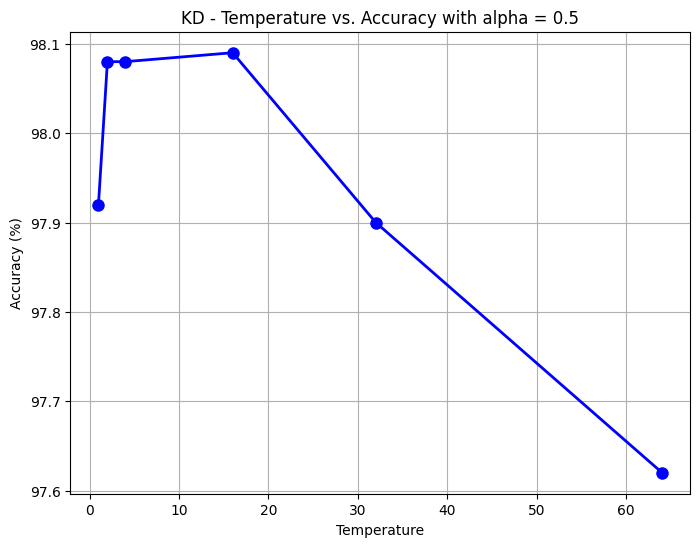

In [ ]:
#plot the teacher accuracy
plt.figure(figsize=(8, 6))
plt.plot(temperaturesToTest, studentAccuracies, color='blue', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('KD - Temperature vs. Accuracy with alpha = 0.5')
plt.xlabel('Temperature')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [ ]:
# perform tuning with alpha at using a temperature of 16 since this was the best result

#complete training for various temperatures and save the accuracies
alphas = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
teacherAccuracies = []
studentAccuracies = [[]]

#reset weights
cnn_model.load_weights("cnn_model.h5")
fc_model.load_weights("fc_model.h5")

print("TEACHER TRAINING RESULTS")
teacherAccuracies.append(train_and_evaluate(cnn_model, compute_teacher_loss))

count = 0
for parameter in alphas:
  ALPHA = parameter
  print("STUDENT TRAINING RESULTS for alpha = " + str(ALPHA))
  studentAccuracies[count].append(train_and_evaluate(fc_model, compute_student_loss))

  if not((count + 1 == len(alphas))):
    studentAccuracies.append([])
    fc_model.load_weights("fc_model.h5")
    count += 1

TEACHER TRAINING RESULTS
Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.83%
Epoch 3: Class_accuracy: 98.11%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.58%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.44%
Epoch 8: Class_accuracy: 98.74%
Epoch 9: Class_accuracy: 98.72%
Epoch 10: Class_accuracy: 98.93%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: 

Class_accuracy: 98.85%
STUDENT TRAINING RESULTS for alpha = 0.15
Epoch 1: Class_accuracy: 97.77%
Epoch 2: Class_accuracy: 97.62%
Epoch 3: Class_accuracy: 97.80%
Epoch 4: Class_accuracy: 97.67%
Epoch 5: Class_accuracy: 97.85%
Epoch 6: Class_accuracy: 97.52%
Epoch 7: Class_accuracy: 97.95%
Epoch 8: Class_accuracy: 97.66%
Epoch 9: Class_accuracy: 98.21%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.90%
Epoch 12: 

Class_accuracy: 97.62%
STUDENT TRAINING RESULTS for alpha = 0.3
Epoch 1: Class_accuracy: 97.04%
Epoch 2: Class_accuracy: 98.12%
Epoch 3: Class_accuracy: 97.79%
Epoch 4: Class_accuracy: 97.87%
Epoch 5: Class_accuracy: 97.94%
Epoch 6: Class_accuracy: 97.92%
Epoch 7: Class_accuracy: 97.70%
Epoch 8: Class_accuracy: 98.20%
Epoch 9: Class_accuracy: 98.10%
Epoch 10: Class_accuracy: 97.89%
Epoch 11: Class_accuracy: 97.91%
Epoch 12: 

Class_accuracy: 98.27%
STUDENT TRAINING RESULTS for alpha = 0.45
Epoch 1: Class_accuracy: 97.77%
Epoch 2: Class_accuracy: 97.82%
Epoch 3: Class_accuracy: 97.60%
Epoch 4: Class_accuracy: 97.76%
Epoch 5: Class_accuracy: 97.85%
Epoch 6: Class_accuracy: 98.10%
Epoch 7: Class_accuracy: 97.94%
Epoch 8: Class_accuracy: 97.68%
Epoch 9: Class_accuracy: 97.86%
Epoch 10: Class_accuracy: 98.13%
Epoch 11: Class_accuracy: 98.00%
Epoch 12: 

Class_accuracy: 97.53%
STUDENT TRAINING RESULTS for alpha = 0.6
Epoch 1: Class_accuracy: 98.07%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 97.61%
Epoch 4: Class_accuracy: 98.03%
Epoch 5: Class_accuracy: 97.87%
Epoch 6: Class_accuracy: 97.40%
Epoch 7: Class_accuracy: 97.90%
Epoch 8: Class_accuracy: 97.98%
Epoch 9: Class_accuracy: 97.89%
Epoch 10: Class_accuracy: 97.70%
Epoch 11: Class_accuracy: 97.97%
Epoch 12: 

Class_accuracy: 97.50%
STUDENT TRAINING RESULTS for alpha = 0.75
Epoch 1: Class_accuracy: 97.89%
Epoch 2: Class_accuracy: 97.65%
Epoch 3: Class_accuracy: 97.92%
Epoch 4: Class_accuracy: 98.17%
Epoch 5: Class_accuracy: 97.92%
Epoch 6: Class_accuracy: 97.93%
Epoch 7: Class_accuracy: 98.00%
Epoch 8: Class_accuracy: 97.91%
Epoch 9: Class_accuracy: 98.10%
Epoch 10: Class_accuracy: 98.08%
Epoch 11: Class_accuracy: 98.10%
Epoch 12: 

Class_accuracy: 98.09%
STUDENT TRAINING RESULTS for alpha = 0.9
Epoch 1: Class_accuracy: 97.45%
Epoch 2: Class_accuracy: 97.60%
Epoch 3: Class_accuracy: 97.60%
Epoch 4: Class_accuracy: 97.48%
Epoch 5: Class_accuracy: 98.04%
Epoch 6: Class_accuracy: 98.00%
Epoch 7: Class_accuracy: 98.17%
Epoch 8: Class_accuracy: 98.24%
Epoch 9: Class_accuracy: 97.85%
Epoch 10: Class_accuracy: 97.94%
Epoch 11: Class_accuracy: 98.09%
Epoch 12: Class_accuracy: 97.61%


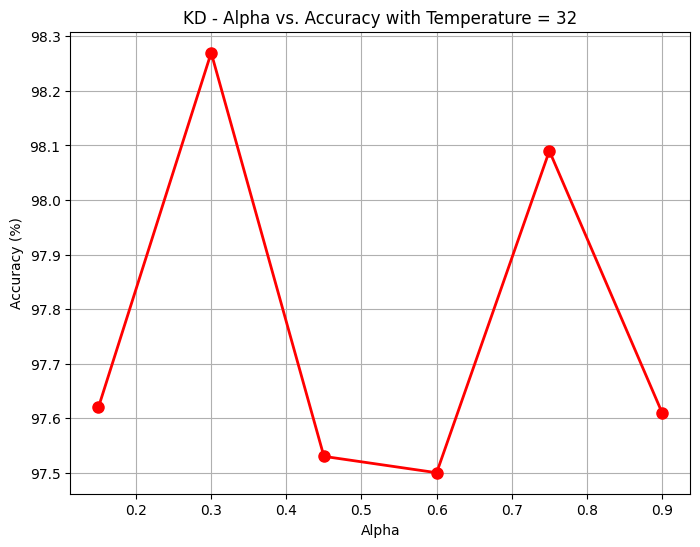

In [ ]:
#plot the teacher accuracy
plt.figure(figsize=(8, 6))
plt.plot(alphas, studentAccuracies, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('KD - Alpha vs. Accuracy with Temperature = 16')
plt.xlabel('Alpha')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [ ]:
# a lower alpha of 0.3 had the best accuracy (98.27%). This value puts most of the
# weight on the distillation loss.

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7

fc_model_no_distillation.add(Flatten())
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(NUM_CLASSES, activation='softmax'))


def compute_plain_cross_entropy_loss(images, ground_truth_labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)

  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=student_subclass_logits)
  cross_entropy_loss = tf.reduce_mean(cross_entropy_loss)

  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

fc_model_no_distillation.save_weights("fc_no_teacher.h5")
fc_model_no_distillation.save("fc_no_teacher.keras")



Epoch 1: Class_accuracy: 94.62%
Epoch 2: Class_accuracy: 96.58%
Epoch 3: Class_accuracy: 97.06%
Epoch 4: Class_accuracy: 97.29%
Epoch 5: Class_accuracy: 97.52%
Epoch 6: Class_accuracy: 97.64%
Epoch 7: Class_accuracy: 97.84%
Epoch 8: Class_accuracy: 97.87%
Epoch 9: Class_accuracy: 97.94%
Epoch 10: Class_accuracy: 97.68%
Epoch 11: Class_accuracy: 97.89%
Epoch 12: Class_accuracy: 97.33%


In [ ]:
# the KD student model performs better at 98.27% and also achieves better performance in less epochs

# Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
# your code start from here for step 8

# number of paramameters for teacher and student (shown through table)

cnn_model.summary()

fc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)           (None, 7744)              0

In [ ]:
# I used the following code from Christos Kyrkou to determine the flops

def net_flops(model, table=False):
    if (table == True):
        print('%25s | %16s | %16s | %16s | %16s | %6s | %6s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS'))
        print('-' * 170)

    t_flops = 0
    t_macc = 0

    for l in model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if ('InputLayer' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if ('Reshape' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if ('Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('Average' in str(l) and 'pool' not in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('BatchNormalization' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('Activation' in str(l) or 'activation' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('pool' in str(l) and ('Global' not in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if ('Flatten' in str(l)):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if ('Dense' in str(l)):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if ('Padding' in str(l)):
            flops = 0

        if (('Global' in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc

        t_flops += flops

        if (table == True):
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.4f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops))
    t_flops = t_flops / factor

    print('\nTotal FLOPS (x 10^6): %10.8f\n' % (t_flops))
    print('\nTotal MACCs: %10.8f\n' % (t_macc))

    return

In [ ]:
print("TEACHER FLOPS")
net_flops(cnn_model)

print("STUDENT FLOPS")
net_flops(fc_model)


TEACHER FLOPS
KerasTensor(type_spec=TensorSpec(shape=(None, 7744), dtype=tf.float32, name=None), name='dropout_2/Identity:0', description="created by layer 'dropout_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dropout_3/Identity:0', description="created by layer 'dropout_3'")

Total FLOPS (x 10^6): 25.59699200


Total MACCs: 12738304.00000000

STUDENT FLOPS
KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), name='flatten_3/Reshape:0', description="created by layer 'flatten_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), name='dense_7/Relu:0', description="created by layer 'dense_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), name='dense_8/Relu:0', description="created by layer 'dense_8'")

Total FLOPS (x 10^6): 2.47430400


Total MACCs: 1237152.00000000



# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12

# only the student loss function needs to be modified

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_STUDENT = 1. #temperature hyperparameter
DISTILLATION_TEMPERATURE_TEACHER = 32. #temperature hyperparameter

BETA = 2*ALPHA*DISTILLATION_TEMPERATURE_TEACHER

SMOOTHING_PARAM = 0.2


def distillation_loss_modified(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      studentTemperature: Union[float, tf.Tensor], teacherTemperature: Union[float, tf.Tensor], smoothingParam):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
 # use seperate temperatures and modify the soft_targets


  soft_targets = tf.nn.softmax(teacher_logits/teacherTemperature)

  u = 1.0/float(NUM_CLASSES)
  norm = tf.norm(soft_targets[0]).numpy()

  soft_targets = tf.math.subtract(soft_targets, u)
  soft_targets = tf.multiply(soft_targets, norm)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / studentTemperature)) * teacherTemperature ** 2

def compute_student_loss_modified(images, ground_truth_labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """

  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss_modified(teacher_subclass_logits, student_subclass_logits,
                                              DISTILLATION_TEMPERATURE_STUDENT, DISTILLATION_TEMPERATURE_TEACHER,
                                              SMOOTHING_PARAM)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  #calculate the student loss the same way the teacher loss was calculated
  studentLoss = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_labels, logits=student_subclass_logits)
  studentLoss = tf.reduce_mean(studentLoss)

  # weighted average - multiply the studentLoss by alpha and distillation loss by BETA
  cross_entropy_loss_value = ALPHA * studentLoss + BETA * distillation_loss_value

  return cross_entropy_loss_value

In [ ]:
# reset the cnn weights
cnn_model.load_weights("cnn_model.h5")

print("RESULTS FOR STATE OF THE ART METHOD EXTRACTIVE DISTILLATION")

# teacher
print("TEACHER TRAINING RESULTS")
train_and_evaluate(cnn_model, compute_teacher_loss)

cnn_model.save("cnn_model_modified.keras")

RESULTS FOR STATE OF THE ART METHOD EXTRACTIVE DISTILLATION
TEACHER TRAINING RESULTS
Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.57%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.44%
Epoch 6: Class_accuracy: 98.73%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.81%
Epoch 9: Class_accuracy: 98.82%
Epoch 10: Class_accuracy: 98.73%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.86%


In [ ]:
# student
print("STUDENT RESULTS FOR EXTRACTIVE DISTILLATION METHOD")
print("STUDENT TRAINING RESULTS")
train_and_evaluate(fc_model, compute_student_loss_modified)

#save the initialization weights so that they can be used to reset later
fc_model.save_weights("fc_model_modified.h5")
cnn_model.save("fc_model_modified.keras")

STUDENT RESULTS FOR EXTRACTIVE DISTILLATION METHOD
STUDENT TRAINING RESULTS
Epoch 1: Class_accuracy: 97.71%
Epoch 2: Class_accuracy: 97.65%
Epoch 3: Class_accuracy: 97.74%
Epoch 4: Class_accuracy: 97.67%
Epoch 5: Class_accuracy: 97.69%
Epoch 6: Class_accuracy: 97.77%
Epoch 7: Class_accuracy: 97.75%
Epoch 8: Class_accuracy: 97.89%
Epoch 9: Class_accuracy: 97.61%
Epoch 10: Class_accuracy: 97.83%
Epoch 11: Class_accuracy: 97.76%
Epoch 12: Class_accuracy: 97.86%


# XAI method to explain models

313/313 [==============================] - 1s 2ms/step


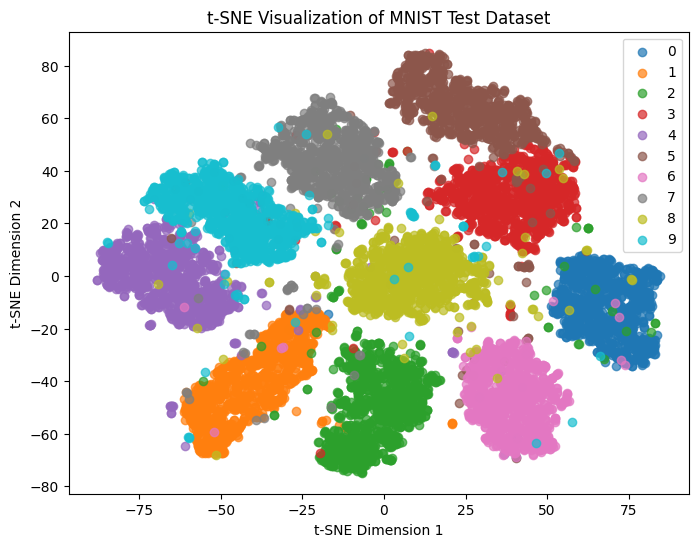

In [ ]:
# for teacher CNN
# Load and preprocess the MNIST test dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

# Reshape the data to (num_samples, 28, 28, 1) for the CNN model
x_test = np.expand_dims(x_test, axis=-1)

# Get the intermediate layer output for the MNIST test dataset
intermediate_layer_model = cnn_model.get_layer('conv2d_1')  # Choose the appropriate layer
feature_extractor = tf.keras.models.Model(inputs=cnn_model.input, outputs=intermediate_layer_model.output)
features_test = feature_extractor.predict(x_test)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_test.reshape(features_test.shape[0], -1))

# Visualize the reduced data using t-SNE
plt.figure(figsize=(8, 6))
for i in range(10):  # Visualize all digits (0 to 9) in different colors
    indices = (y_test == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=str(i), alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MNIST Test Dataset')
plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


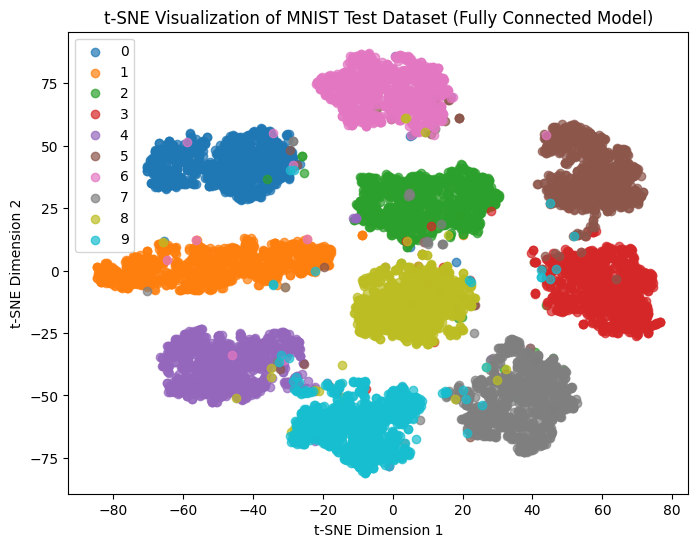

In [ ]:
# Load and preprocess the MNIST test dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

# Get the intermediate layer output (or output before the softmax layer) for the MNIST test dataset
intermediate_layer_model = fc_model.get_layer('dense_3')  # Choose the appropriate layer
feature_extractor = tf.keras.models.Model(inputs=fc_model.input, outputs=intermediate_layer_model.output)
features_test = feature_extractor.predict(x_test)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_test)

# Visualize the reduced data using t-SNE
plt.figure(figsize=(8, 6))
for i in range(10):  # Visualize all digits (0 to 9) in different colors
    indices = (y_test == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=str(i), alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MNIST Test Dataset (Fully Connected Model)')
plt.legend()
plt.show()


313/313 [==============================] - 1s 4ms/step


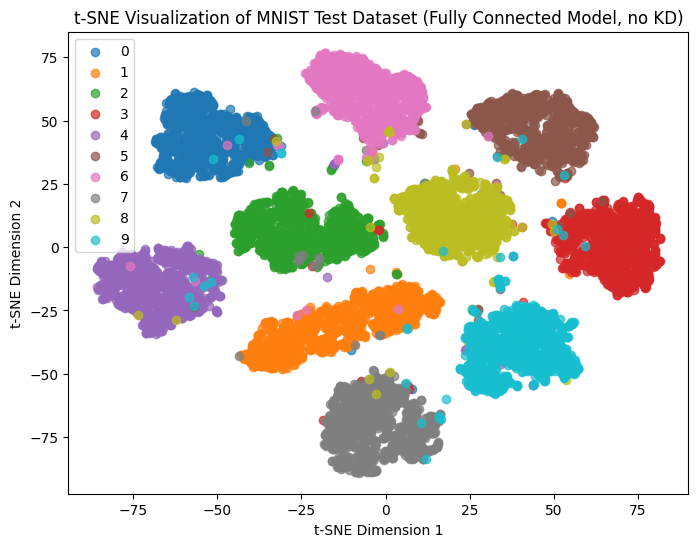

In [ ]:
# Load and preprocess the MNIST test dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

# Get the intermediate layer output (or output before the softmax layer) for the MNIST test dataset
intermediate_layer_model = fc_model_no_distillation.get_layer('dense_6')  # Choose the appropriate layer
feature_extractor = tf.keras.models.Model(inputs=fc_model_no_distillation.input, outputs=intermediate_layer_model.output)
features_test = feature_extractor.predict(x_test)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_test)

# Visualize the reduced data using t-SNE
plt.figure(figsize=(8, 6))
for i in range(10):  # Visualize all digits (0 to 9) in different colors
    indices = (y_test == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=str(i), alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MNIST Test Dataset (Fully Connected Model, no KD)')
plt.legend()
plt.show()


In [ ]:
# for teacher CNN
# Load and preprocess the MNIST test dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

# Reshape the data to (num_samples, 28, 28, 1) for the CNN model
x_test = np.expand_dims(x_test, axis=-1)

# Get the intermediate layer output for the MNIST test dataset
intermediate_layer_model = cnn_model.get_layer('conv2d_1')  # Choose the appropriate layer
feature_extractor = tf.keras.models.Model(inputs=cnn_model.input, outputs=intermediate_layer_model.output)
features_test = feature_extractor.predict(x_test)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_test.reshape(features_test.shape[0], -1))

# Visualize the reduced data using t-SNE
plt.figure(figsize=(8, 6))
for i in range(10):  # Visualize all digits (0 to 9) in different colors
    indices = (y_test == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=str(i), alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MNIST Test Dataset')
plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


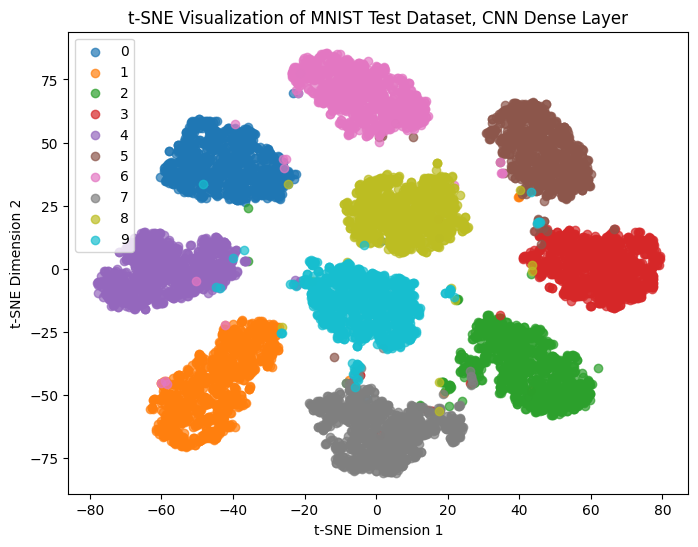

In [ ]:
# for teacher CNN linear layers
# Load and preprocess the MNIST test dataset
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

# Reshape the data to (num_samples, 28, 28, 1) for the CNN model
x_test = np.expand_dims(x_test, axis=-1)

# Get the intermediate layer output for the MNIST test dataset
intermediate_layer_model = cnn_model.get_layer('dense')  # Choose the appropriate layer
feature_extractor = tf.keras.models.Model(inputs=cnn_model.input, outputs=intermediate_layer_model.output)
features_test = feature_extractor.predict(x_test)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_test.reshape(features_test.shape[0], -1))

# Visualize the reduced data using t-SNE
plt.figure(figsize=(8, 6))
for i in range(10):  # Visualize all digits (0 to 9) in different colors
    indices = (y_test == i)
    plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=str(i), alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of MNIST Test Dataset, CNN Dense Layer')
plt.legend()
plt.show()
